In [39]:
import pandas as pd
import numpy as np 

from sqlalchemy import create_engine
import matplotlib.pyplot as plt

import os
import configparser

from sklearn.preprocessing import RobustScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, classification_report, auc

from lifelines import KaplanMeierFitter

In [2]:
config = configparser.ConfigParser()
# Read the credentials file
config.read('postgress_pass.txt')

['postgress_pass.txt']

In [3]:
# credential
username = config.get('DEFAULT', 'username')
password = config.get('DEFAULT', 'password')
hostname = config.get('DEFAULT', 'hostname')
database_name = config.get('DEFAULT', 'database_name')
port = '5432'  # Default port for PostgreSQL
# Create the database engine
engine = create_engine(f'postgresql://{username}:{password}@{hostname}:{port}/{database_name}')

In [4]:
query_string = "Select* from water_meter_status"

In [5]:
# Execute the query and read the results into a DataFrame
df = pd.read_sql_query(query_string, engine)
df.head()

,District,Account Type,Meter Manufacturer,Meter Type,Meter Mileage,Installed Period,Status
0,HULU LANGAT,Landed Household,George Kent Malaysia,Mechanical Meter - Plastic Body & Piston Volum...,35369.246647,1.179056,Working
1,HULU LANGAT,Landed Household,Aqua Flo Sdn. Bhd.,Mechanical Meter - Plastic Body & Piston Volum...,32078.607636,0.943631,Working
2,HULU LANGAT,Landed Household,Aqua Flo Sdn. Bhd.,Mechanical Meter - Plastic Body & Piston Volum...,29080.863836,1.545652,Working
3,HULU LANGAT,Landed Household,George Kent Malaysia,Mechanical Meter - Ductile Iron Body & Woltman...,34195.282401,1.155983,Working
4,HULU LANGAT,Landed Household,Aqua Flo Sdn. Bhd.,Mechanical Meter - Brass Body & Piston Volumet...,33788.936676,1.188148,Working


# Data Modelling

## 1. Data Preparation

### 1.1 Scaling

In [6]:
X = df.drop(columns=['Status'])
y = df['Status']

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, range(len(df)), test_size=0.2, random_state=42, shuffle=True)


In [8]:
# Initialize the RobustScaler
robust_scaler = RobustScaler()

# Columns to scale
columns_to_scale = ['Meter Mileage', 'Installed Period']

# Fit the scaler on the training data and transform it
X_train_scaled = robust_scaler.fit_transform(X_train[columns_to_scale])
X_test_scaled = robust_scaler.transform(X_test[columns_to_scale])

In [9]:
# Create DataFrames from the scaled arrays, ensuring correct indices
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=columns_to_scale, index=indices_train)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=columns_to_scale, index=indices_test)

In [10]:
X_train = X_train.drop(columns=columns_to_scale).join(X_train_scaled_df)
X_test = X_test.drop(columns=columns_to_scale).join(X_test_scaled_df)

In [19]:
categorical_columns = ['District', 'Account Type', 'Meter Manufacturer', 'Meter Type']

X_train = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)


In [20]:
rf_scale = RandomForestClassifier(random_state=42)

In [21]:
rf_trained = rf_scale.fit(X_train, y_train)
predictions = rf_trained.predict(X_test)

In [31]:
# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, pos_label='Working')
conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions)

In [34]:
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.9748418124396072
F1 Score: 0.9847544204322201
Confusion Matrix:
 [[102640  11925]
 [  3983 513771]]
Classification Report:
               precision    recall  f1-score   support

      Failed       0.96      0.90      0.93    114565
     Working       0.98      0.99      0.98    517754

    accuracy                           0.97    632319
   macro avg       0.97      0.94      0.96    632319
weighted avg       0.97      0.97      0.97    632319



In [26]:
y_scores = rf_trained.predict_proba(X_test)[:, 1]

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_scores)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9764104327222868


In [37]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label='Working')
# Calculate the AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

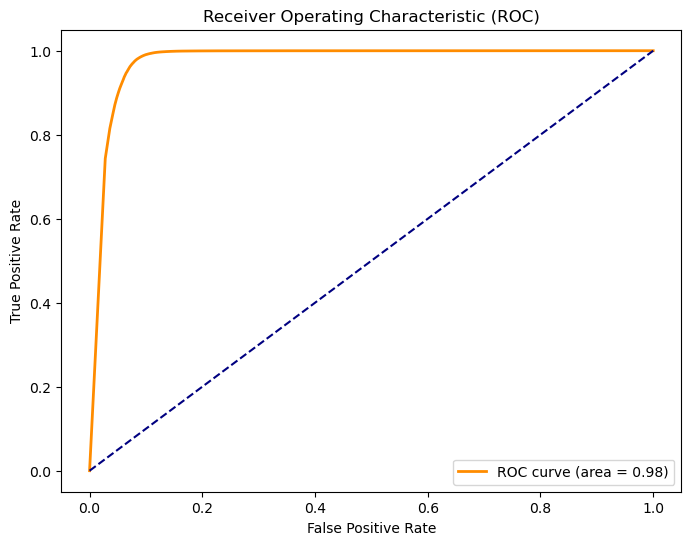

In [38]:
# Plot the ROC Curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()